In [1]:
import numpy as np
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Categorical
from typing import Type, Any, Callable, Union, List, Optional
import gym
import gym_Aircraft
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [3]:
class FClayer(nn.Module):
    def __init__(self, innodes: int, nodes: int):
        super(FClayer, self).__init__()
        self.fc=nn.Linear(innodes,nodes)
        self.act=nn.LeakyReLU(0.2, inplace=True)
    def forward(self, x: Tensor) -> Tensor:
        out=self.fc(x)
        out=self.act(out)
        return out
class WaveNET(nn.Module):
    def __init__(self, block: Type[Union[FClayer]], planes: List[int], nodes: List[int], num_classes: int = 3
                ) -> None:
        super(WaveNET, self).__init__()
        self.innodes=5
        
        self.layer1=self._make_layer(block, planes[0], nodes[0])
        self.layer2=self._make_layer(block, planes[1], nodes[1])
        self.layer3=self._make_layer(block, planes[2], nodes[2])
        
        self.fin_fc=nn.Linear(self.innodes,num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    
    def _make_layer(self, block: Type[Union[FClayer]], planes: int, nodes: int) -> nn.Sequential:

        layers = []
        layers.append(block(self.innodes, nodes))
        self.innodes = nodes
        for _ in range(1, planes):
            layers.append(block(self.innodes, nodes))

        return nn.Sequential(*layers)

        
    def _forward_impl(self, x: Tensor) -> Tensor:
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fin_fc(x)
        
        return x
    
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, actor_model, critic_model):
        super(ActorCritic, self).__init__()

        # actor
        self.action_layer = actor_model
        
        # critic
        self.value_layer = critic_model
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [5]:
class PPO:
    def __init__(self, actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(actor_model, critic_model).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(actor_model, critic_model).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())

In [6]:
n_episodes = 1000
succeed_coef = 7000         # maximum reward when agent avoids collision
collide_coef = -1000        # reward when agent doesn't avoid collision
change_cmd_penalty = -100   # reward when agent changes command values
cmd_penalty = -0.05         # coefficient of penaly on using command
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
max_timesteps = 300
env_name = "acav-v0"
env = gym.make(env_name)
env.env.__init__(succeed_coef, collide_coef, change_cmd_penalty, cmd_penalty)

In [7]:
actor_model = torch.load("./Custom_model_fin")
critic_model = torch.load("./Custom_model_fin")
mean = np.load('mean_test.npy')
std = np.load('std_test.npy')
num_final_nodes = critic_model.fin_fc.in_features
critic_model.fin_fc = nn.Linear(num_final_nodes, 1)
num_final_nodes = actor_model.fin_fc.in_features
num_output_nodes = actor_model.fin_fc.out_features
actor_model.fin_fc = nn.Sequential(nn.Linear(num_final_nodes, num_output_nodes), nn.Softmax(dim=-1))

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type WaveNET. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type FClayer. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/jupyter-kunwoopark/.local/lib/python3.7/sit

In [8]:
memory = Memory()
ppo = PPO(actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip)
ppo.policy_old.load_state_dict(torch.load("PPO_1.28_2.pth"))

<All keys matched successfully>

In [9]:
total_res=[]
rewards   = []
for ep in range(1, n_episodes+1):
    res_list = np.zeros(11)
    ep_reward = 0
    state = env.reset()
    for t in range(max_timesteps):
        state = (state-mean)/std
        action = ppo.policy_old.act(state, memory)
        state, reward, done, info = env.step(action)
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list,height_diff=info["info"]
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        ep_reward += reward
        if done:
            res_list=np.delete(res_list,0,0)
            total_res.append(res_list)
            rewards.append(ep_reward)
            break

In [10]:
min_distance = []
for i in range (n_episodes):
    min_distance.append(min(total_res[i][:,1]))

In [11]:
np.mean(np.array(min_distance))

134.26365781756903

In [12]:
min_distance

[102.38432137129233,
 166.00184935852786,
 99.56882472363614,
 114.01937144521868,
 114.9938625261015,
 127.37032381123879,
 192.7174391706099,
 132.49380026737805,
 107.45777878434917,
 200.17101600344802,
 146.68234006850082,
 101.57322444523415,
 172.3849752144502,
 107.75878945940762,
 106.72947019030734,
 105.49684774209729,
 167.1787316797458,
 143.61656722120676,
 128.31073323613927,
 122.77405646421315,
 221.46348186870907,
 186.10176655420835,
 117.42260170114086,
 132.7246711386877,
 101.52926387335839,
 117.24341579006128,
 106.16349346691615,
 131.74418632845084,
 201.14926383953926,
 116.70479061941607,
 104.1820242874288,
 107.74881736786051,
 203.84684145417418,
 136.7816558510447,
 122.98562605523473,
 99.59590804760832,
 99.03703943980251,
 136.69692515571504,
 105.18506084428319,
 134.8940695070455,
 122.97806264842971,
 103.0157225380881,
 113.95015501877937,
 99.99783404372664,
 185.1020084145581,
 101.2128202408507,
 113.45029782418706,
 106.61365199180699,
 102.19

In [13]:
np.var(min_distance)

1281.7522582978893

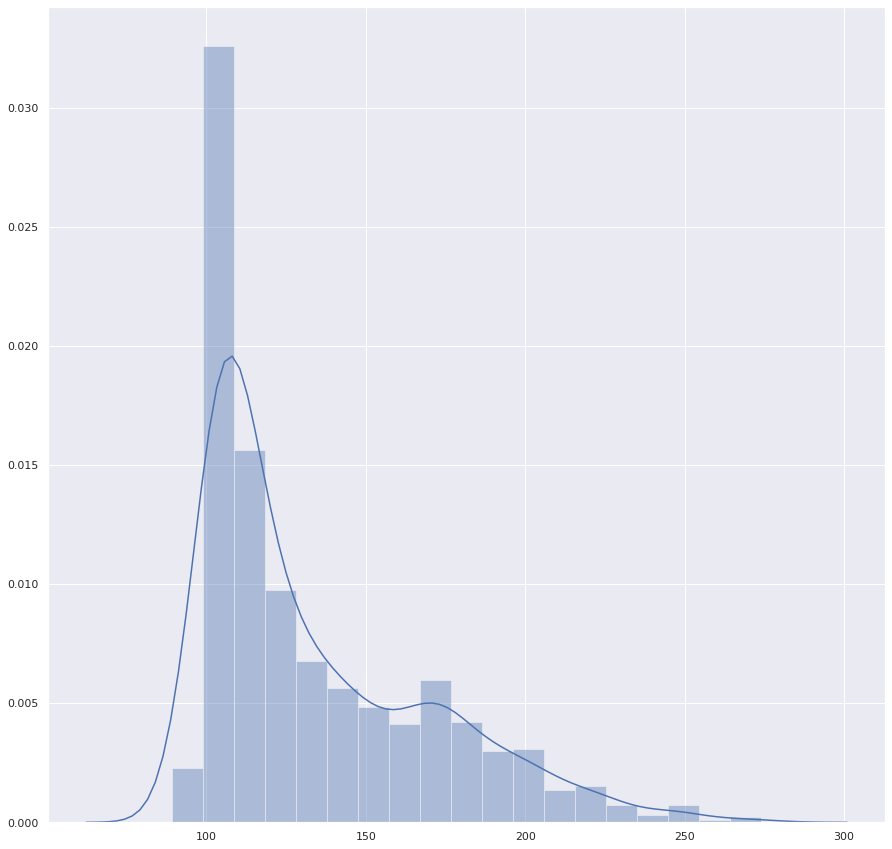

In [14]:
plt.figure(figsize=(15,15))
sns.set(color_codes=True)
sns.distplot(min_distance)

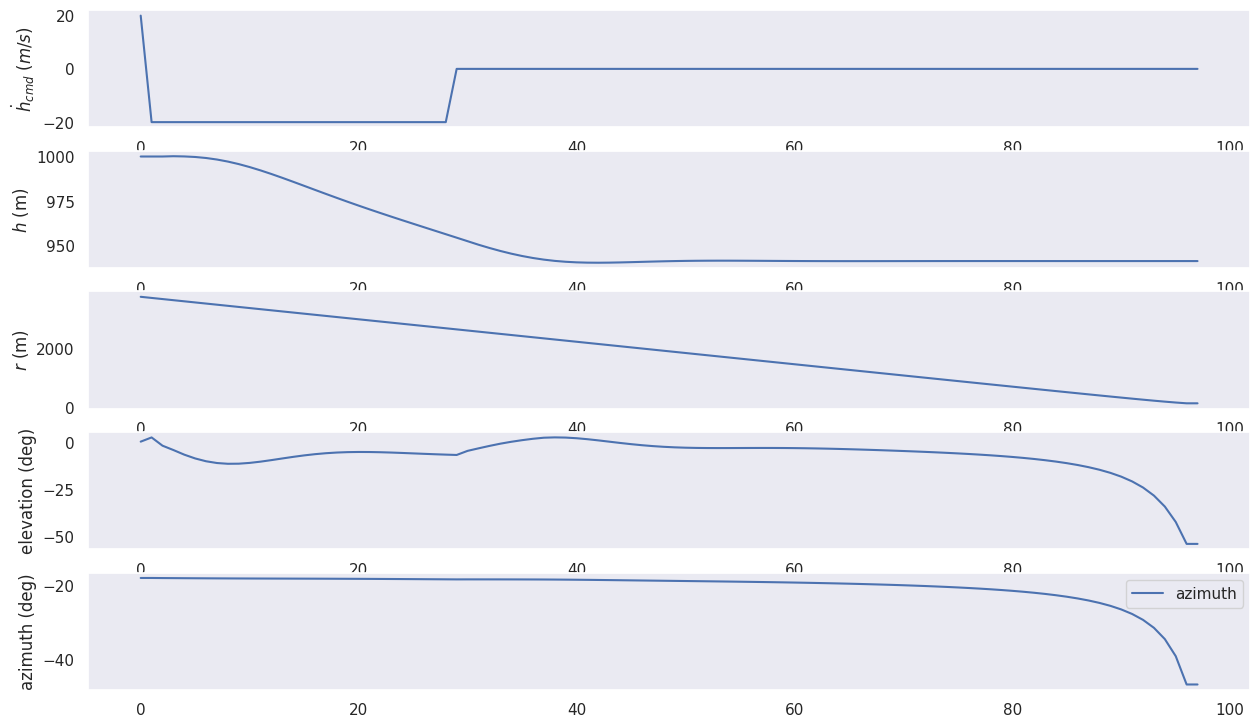

In [15]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[10]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()